In [123]:
import pandas as pd
from scipy.io import arff
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn import set_config
import matplotlib.pyplot as plt
import keras
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.callbacks import EarlyStopping
import random
import keras_tuner as kt
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

data = pd.DataFrame(arff.loadarff('C:/Users/Darrius/Downloads/dataset_31_credit-g.arff')[0])

for col in data.columns:
    data[col] = data[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

pd.set_option('display.max_columns', None)
random.seed(1)
data

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12.0,existing paid,furniture/equipment,1736.0,<100,4<=X<7,3.0,female div/dep/mar,none,4.0,real estate,31.0,none,own,1.0,unskilled resident,1.0,none,yes,good
996,<0,30.0,existing paid,used car,3857.0,<100,1<=X<4,4.0,male div/sep,none,4.0,life insurance,40.0,none,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes,good
997,no checking,12.0,existing paid,radio/tv,804.0,<100,>=7,4.0,male single,none,4.0,car,38.0,none,own,1.0,skilled,1.0,none,yes,good
998,<0,45.0,existing paid,radio/tv,1845.0,<100,1<=X<4,4.0,male single,none,4.0,no known property,23.0,none,for free,1.0,skilled,1.0,yes,yes,bad


In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

In [125]:
for column in data.columns:   
    print(data[column].value_counts())
    print()


checking_status
no checking    394
<0             274
0<=X<200       269
>=200           63
Name: count, dtype: int64

duration
24.0    184
12.0    179
18.0    113
36.0     83
6.0      75
15.0     64
9.0      49
48.0     48
30.0     40
21.0     30
10.0     28
60.0     13
27.0     13
42.0     11
11.0      9
20.0      8
8.0       7
4.0       6
45.0      5
7.0       5
39.0      5
14.0      4
13.0      4
33.0      3
28.0      3
54.0      2
16.0      2
22.0      2
47.0      1
5.0       1
26.0      1
72.0      1
40.0      1
Name: count, dtype: int64

credit_history
existing paid                     530
critical/other existing credit    293
delayed previously                 88
all paid                           49
no credits/all paid                40
Name: count, dtype: int64

purpose
radio/tv               280
new car                234
furniture/equipment    181
used car               103
business                97
education               50
repairs                 22
domestic appliance  

In [126]:
set_config(transform_output="pandas")

oe = OrdinalEncoder(categories=[
    ['no checking', '<0', '0<=X<200', '>=200'],
    ['unemployed', '<1', '1<=X<4', '4<=X<7', '>=7'],
    ['no known savings', '<100', '100<=X<500', '500<=X<1000', '>=1000'],
    ['bad', 'good'], 
    ['none', 'yes'],
    ['no', 'yes']
])

ct = make_column_transformer(
  (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), [
    'credit_history', 'purpose', 'personal_status', 'other_parties', 
    'property_magnitude', 'other_payment_plans', 'housing', 'job'
  ]),
  (oe, [
    'checking_status', 'employment', 'savings_status', 
    'class', 'own_telephone', 'foreign_worker'
  ]),
  remainder='passthrough',
  verbose_feature_names_out=False
)

data_ct = ct.fit_transform(data)

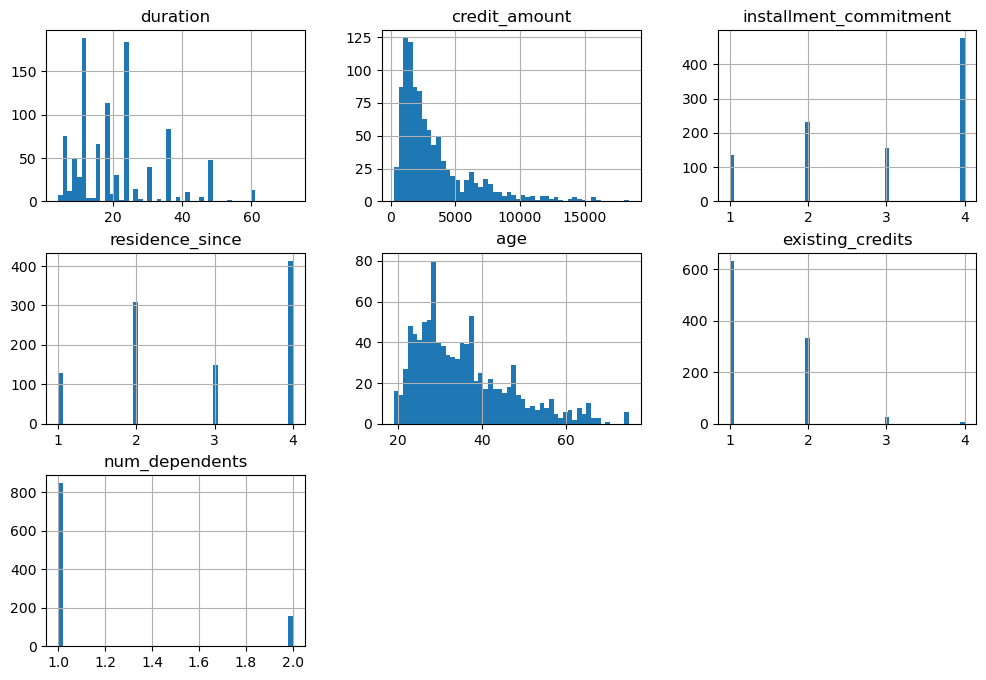

In [127]:
data.hist(bins=50, figsize=(12, 8))
plt.show()

In [128]:
X = data_ct[['duration']] 
y = data_ct['class']
X_train_bench, X_test_bench, y_train_bench, y_test_bench = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train_bench, y_train_bench)

y_pred = lr.predict(X_test_bench)
y_pred_binary = (y_pred >= 0.5).astype(int)
accuracy = accuracy_score(y_test_bench, y_pred_binary)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test_bench, y_pred_binary))


Accuracy: 0.71
              precision    recall  f1-score   support

         0.0       0.53      0.14      0.22        59
         1.0       0.72      0.95      0.82       141

    accuracy                           0.71       200
   macro avg       0.63      0.54      0.52       200
weighted avg       0.67      0.71      0.64       200



In [129]:
X_main, X_test, y_main, y_test = \
    train_test_split(data_ct.drop('class', axis = 1), data_ct['class'], test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = \
    train_test_split(X_main, y_main, test_size=0.11, random_state=1)

ct2 = make_column_transformer(
  (StandardScaler(), ['duration', 'credit_amount', 'age']),
  remainder='passthrough',
  verbose_feature_names_out=False
)

ct2.fit(X_train)
X_train = ct2.transform(X_train)
X_val = ct2.transform(X_val)
X_test = ct2.transform(X_test)

y_train = y_train.values.astype(int)
y_val = y_val.values.astype(int)

In [130]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int("numHiddenLayers", 1, 4)):
      model.add(
        Dense(
            hp.Choice(f"neurons_{i}", [8, 16, 32, 64]),
            activation=hp.Choice("activation",
              ["relu", "leaky_relu", "tanh"]),
        )
      )
      model.add(
        Dropout(0.5)
      )
  
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

tuner = kt.BayesianOptimization(
  build_model,
  objective="val_loss",
  directory="bayesian-search",
  max_trials=10)

es = EarlyStopping(patience=3,
  restore_best_weights=True)

tuner.search(X_train, y_train,
  epochs=100, callbacks = [es],
  validation_data=(X_val, y_val))

best_model = tuner.get_best_models()[0]
tuner.results_summary(1)

Reloading Tuner from bayesian-search\untitled_project\tuner0.json
Results summary
Results in bayesian-search\untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 08 summary
Hyperparameters:
numHiddenLayers: 2
neurons_0: 16
activation: leaky_relu
neurons_1: 32
neurons_2: 64
neurons_3: 16
Score: 0.5371410846710205


c:\Users\Darrius\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [131]:
es = EarlyStopping(restore_best_weights=True, patience=100, monitor="val_accuracy", mode="max")

hist = best_model.fit(X_train, y_train, epochs=1000, callbacks=[es], validation_data=(X_val, y_val))

Epoch 1/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7045 - loss: 0.5443 - val_accuracy: 0.6869 - val_loss: 0.5415
Epoch 2/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6820 - loss: 0.5497 - val_accuracy: 0.6869 - val_loss: 0.5414
Epoch 3/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6971 - loss: 0.5250 - val_accuracy: 0.6970 - val_loss: 0.5397
Epoch 4/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7470 - loss: 0.5117 - val_accuracy: 0.6869 - val_loss: 0.5523
Epoch 5/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7351 - loss: 0.5172 - val_accuracy: 0.6970 - val_loss: 0.5476
Epoch 6/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7395 - loss: 0.5171 - val_accuracy: 0.6869 - val_loss: 0.5484
Epoch 7/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7179 - loss: 0.5042 - val_accuracy: 0.6869 - val_loss: 0.5474
Epoch 8/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7318 - loss: 0.5037 - val_accuracy: 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

         0.0       0.55      0.40      0.46        30
         1.0       0.77      0.86      0.81        70

    accuracy                           0.72       100
   macro avg       0.66      0.63      0.64       100
weighted avg       0.70      0.72      0.71       100



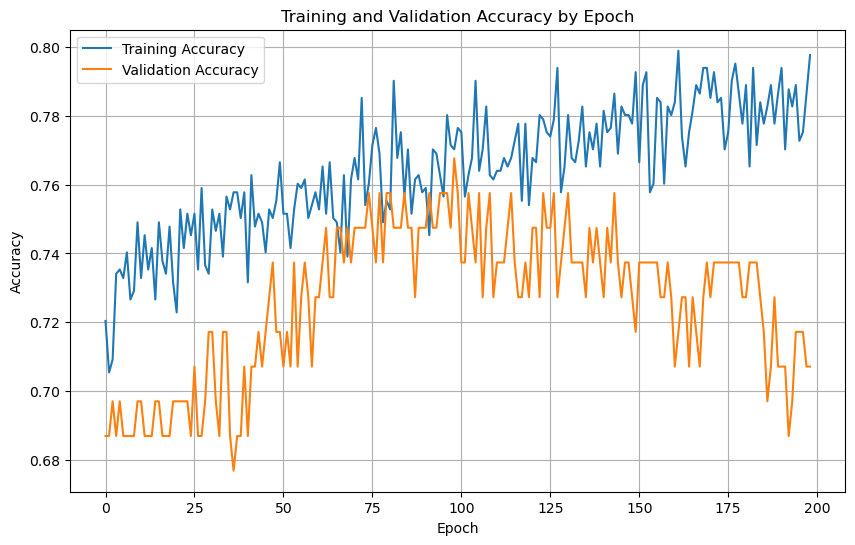

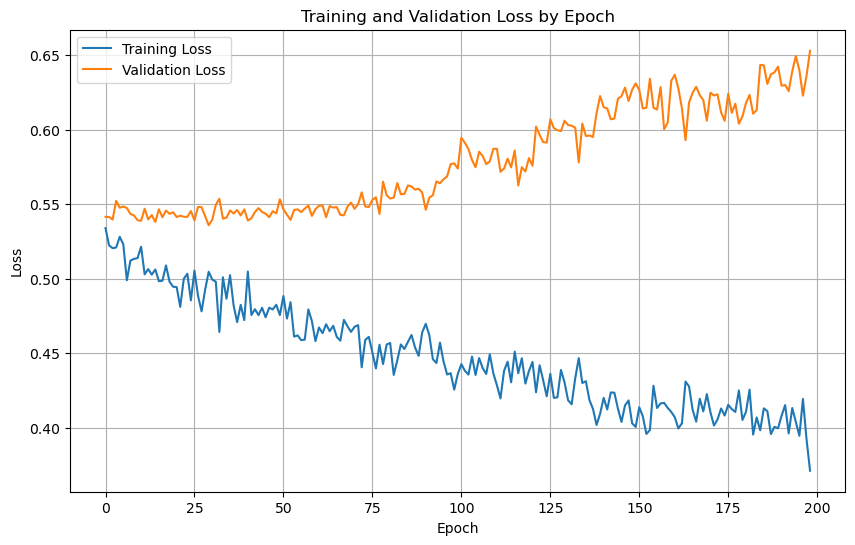

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape            ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ dense (Dense)                  │ (None, 16)              │          784 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dropout (Dropout)              │ (None, 16)              │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dense_1 (Dense)                │ (None, 32)              │          544 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dropout_1 (Dropout)            │ (None, 32)              │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dense_2 (Dense)                │ (None, 1)               │           33 │
└────────────────────────────────┴─────────────────────────┴──────────────┘

 Total params: 4,085 (15.96 KB)

 Trainable params: 1,361 (5.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,724 (10.64 KB)

In [132]:
y_pred = best_model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

print(classification_report(y_test, y_pred_binary))

plt.figure(figsize=(10, 6))
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

best_model.summary(line_length=75)

In [133]:
CONTINUOUS_FEATURES = ['duration', 'age', 'credit_amount']
wide_input_data = X_train[CONTINUOUS_FEATURES]
deep_input_data = X_train.drop(columns=CONTINUOUS_FEATURES)

wide_input = Input(shape = (3,))
wide_output = Dense(1, activation='linear')(wide_input)

deep_input = Input (shape = (45,))
deep = Dense(64, activation='relu')(deep_input)
dropout = Dropout(0.5)(deep)
deep = Dense(32, activation='relu')(dropout)
deep_output = Dense(1, activation='linear')(deep)

concat = concatenate([wide_output, deep_output])
output = Dense(1, activation='sigmoid')(concat)

model = Model(inputs = [wide_input, deep_input], outputs = output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

history = model.fit(
    [wide_input_data, deep_input_data], y_train, 
    validation_data=([X_val[CONTINUOUS_FEATURES], 
                      X_val.drop(columns=CONTINUOUS_FEATURES)], y_val), 
    epochs=1000, callbacks=[early_stopping])



Epoch 1/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6140 - loss: 0.7373 - val_accuracy: 0.6364 - val_loss: 0.6991
Epoch 2/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6769 - loss: 0.6808 - val_accuracy: 0.6364 - val_loss: 0.6726
Epoch 3/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6865 - loss: 0.6481 - val_accuracy: 0.6364 - val_loss: 0.6618
Epoch 4/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7102 - loss: 0.5988 - val_accuracy: 0.6667 - val_loss: 0.6268
Epoch 5/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6883 - loss: 0.6049 - val_accuracy: 0.6465 - val_loss: 0.6370
Epoch 6/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7049 - loss: 0.6050 - val_accuracy: 0.6667 - val_loss: 0.6112
Epoch 7/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6825 - loss: 0.5833 - val_accuracy: 0.6768 - val_loss: 0.6013
Epoch 8/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6729 - loss: 0.5788 - val_accuracy: 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
              precision    recall  f1-score   support

         0.0       0.53      0.33      0.41        30
         1.0       0.75      0.87      0.81        70

    accuracy                           0.71       100
   macro avg       0.64      0.60      0.61       100
weighted avg       0.69      0.71      0.69       100



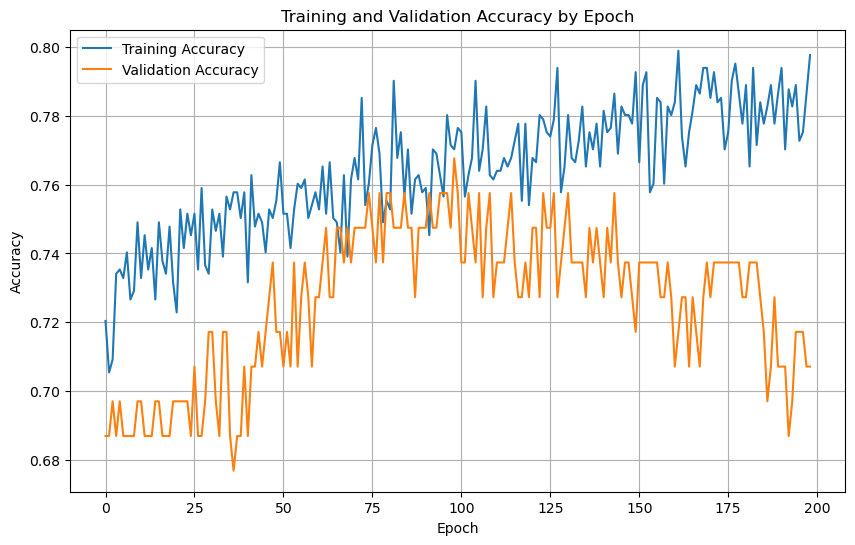

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃   Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 45)        │         0 │ -                 │
│ (InputLayer)        │                   │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     2,944 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │         0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ input_layer_1       │ (None, 3)         │         0 │ -                 │
│ (InputLayer)        │                   │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │     2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         4 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │        33 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ concatenate         │ (None, 2)         │         0 │ dense_3[0][0],    │
│ (Concatenate)       │                   │           │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         3 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴───────────┴───────────────────┘

 Total params: 15,194 (59.36 KB)

 Trainable params: 5,064 (19.78 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,130 (39.57 KB)

In [134]:
y_pred = model.predict([X_test[CONTINUOUS_FEATURES], 
                      X_test.drop(columns=CONTINUOUS_FEATURES)])
y_pred_binary = (y_pred >= 0.5).astype(int)

print(classification_report(y_test, y_pred_binary))

plt.figure(figsize=(10, 6))
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

model.summary(line_length=75)